[Tensorflow official guide: tf.keras model used in autograph](https://tensorflow.google.cn/guide/autograph#advanced_example_an_in-graph_training_loop) <br>
运行环境: tensorflow-1.15.0-rc1

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

(60000, 28, 28) (10000, 28, 28)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.
gradient back propogation training
train accuracy: 0.95600003
test accuracy: 0.95500004


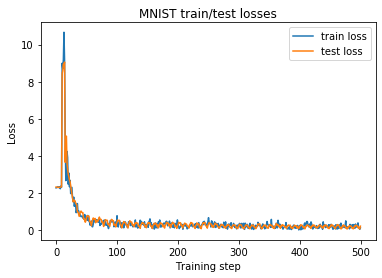

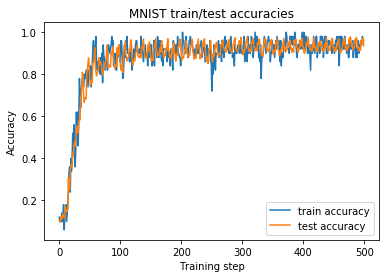

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
layers = tf.keras.layers
from tensorflow import contrib
autograph = contrib.autograph

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import sys
import os
MNIST_NPZ='/home/brooksj/VSCode/python/tensorflow/tensorflow_in_action/input/mnist.npz'

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data(MNIST_NPZ)
tf.enable_eager_execution()
print(train_images.shape, test_images.shape)

def mlp_model(input_shape):
  model = tf.keras.Sequential((
      tf.keras.layers.Dense(100, activation='relu', input_shape=input_shape),
      tf.keras.layers.Dense(100, activation='relu'),
      tf.keras.layers.Dense(10, activation='softmax')))
  model.build()
  return model


def predict(m, x, y):
  y_p = m(tf.reshape(x, (-1, 28 * 28)))
  losses = tf.keras.losses.categorical_crossentropy(y, y_p)
  l = tf.reduce_mean(losses)
  accuracies = tf.keras.metrics.categorical_accuracy(y, y_p)
  accuracy = tf.reduce_mean(accuracies)
  return l, accuracy


def fit(m, x, y, opt):
  l, accuracy = predict(m, x, y)
  # Autograph automatically adds the necessary <a href="./../api_docs/python/tf/control_dependencies"><code>tf.control_dependencies</code></a> here.
  # (Without them nothing depends on `opt.minimize`, so it doesn't run.)
  # This makes it much more like eager-code.
  train_op = opt.minimize(l)
  # warning: 测试发现1.15-rc1版本tf的autograph没有自动添加control_dependencies，
  # 需要手动在返回前添加训练操作的依赖
  with tf.control_dependencies([train_op]):
    print('gradient back propogation training')
    return l, accuracy
    # l, accuracy = predict(m, x, y)



def setup_mnist_data(is_training, batch_size):
  if is_training:
    ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    ds = ds.shuffle(batch_size * 10)
  else:
    ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

  ds = ds.repeat()
  ds = ds.batch(batch_size)
  return ds


def get_next_batch(ds):
  itr = ds.make_one_shot_iterator()
  image, label = itr.get_next()
  x = tf.cast(image, dtype=tf.float32) / 255.0
  y = tf.one_hot(tf.squeeze(label), 10)
  return x, y

# Use `recursive = True` to recursively convert functions called by this one.
# warning: 经测试转换后的代码无法打印训练测试信息
@autograph.convert(recursive=True, optional_features=autograph.Feature.ALL)
def train(train_ds, test_ds, hp):
  m = mlp_model((28 * 28,))
  opt = tf.train.AdamOptimizer(hp.learning_rate)

  # We'd like to save our losses to a list. In order for AutoGraph
  # to convert these lists into their graph equivalent,
  # we need to specify the element type of the lists.
  train_losses = []
  autograph.set_element_type(train_losses, tf.float32)
  test_losses = []
  autograph.set_element_type(test_losses, tf.float32)
  train_accuracies = []
  autograph.set_element_type(train_accuracies, tf.float32)
  test_accuracies = []
  autograph.set_element_type(test_accuracies, tf.float32)


  # This entire training loop will be run in-graph.
  i = tf.constant(0)
  while i < hp.max_steps:
    train_x, train_y = get_next_batch(train_ds)
    test_x, test_y = get_next_batch(test_ds)

    step_train_loss, step_train_accuracy = fit(m, train_x, train_y, opt)
    step_test_loss, step_test_accuracy = predict(m, test_x, test_y)
    if i % 50 == 0:
      print('Step', i, 'train loss:', step_train_loss, 'test loss:',
            step_test_loss, 'train accuracy:', step_train_accuracy,
            'test accuracy:', step_test_accuracy)
    train_losses.append(step_train_loss)
    test_losses.append(step_test_loss)
    train_accuracies.append(step_train_accuracy)
    test_accuracies.append(step_test_accuracy)
    i += 1

  # We've recorded our loss values and accuracies
  # to a list in a graph with AutoGraph's help.
  # In order to return the values as a Tensor,
  # we need to stack them before returning them.
  return (autograph.stack(train_losses), autograph.stack(test_losses),
          autograph.stack(train_accuracies), autograph.stack(test_accuracies))

with tf.Graph().as_default() as g:
  hp = tf.contrib.training.HParams(
      learning_rate=0.005,
      max_steps=500,
  )
  train_ds = setup_mnist_data(True, 50)
  test_ds = setup_mnist_data(False, 1000)
  (train_losses, test_losses, train_accuracies, 
  test_accuracies) = train(train_ds, test_ds, hp)
  
  init = tf.global_variables_initializer()


with tf.Session(graph=g) as sess:
  sess.run(init)
  (train_losses, test_losses, train_accuracies, 
  test_accuracies) = sess.run([train_losses, 
  test_losses, train_accuracies, test_accuracies])
  print("train accuracy:", np.mean(train_accuracies[-5:]))
  print("test accuracy:", np.mean(test_accuracies[-5:]))

plt.figure()
plt.title('MNIST train/test losses')
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.xlabel('Training step')
plt.ylabel('Loss')
plt.figure()
plt.title('MNIST train/test accuracies')
plt.plot(train_accuracies, label='train accuracy')
plt.plot(test_accuracies, label='test accuracy')
plt.legend(loc='lower right')
plt.xlabel('Training step')
plt.ylabel('Accuracy')
plt.show()